<p style="text-align: center; font-size:16px;"> <em> Please feel free to copy or reproduce any part of this notebook for non-commercial use with proper attribution </em></p>

# In this notebook...

In this notebook we will:
- Look at a recap of ordinary autoencoders
- Understand the structure of convolutional autoencoders (CAEs)
- Understand why CAEs are uniquely appropriate for dimensionality reduction in image/serial data
- Learn how to built/train a CAE, utilizing the MNIST dataset in the process
- Explore how our decoder behaves as we travel through the latent space
- Directly observe latent space encodings of similar and distinct digits
- Build a CAE for noise reduction
- Build a CNN for MNIST classification
- Explore whether or not using a CAE as a denoising preprocessing step for a classification CNN is worthwhile

# Introduction

Today we're going to explore the topic of **Convolutional Autoencoders**. First, let's go through a brief recap of _ordinary_ autoencoders.

### Ordinary Autoencoders

An autoencoder is a type of **neural network** that seeks to learn a compressed version, or **encoding** of the data that it is trained on. It learns the salient features of the data and maps them to a reduced-dimensionality *encoding* or _latent space_. Below we can see the structure of an ordinary autoencoder, where the input features are mapped to a compressed representation using a simple feedforward network called an **encoder**. This representation can then be mapped back to our original space with the **decoder** to get a **reconstruction** of the original data. Together, the encoder and decoder constitute an autoencoder.

<img src="autoencoder_struct.png">
<div style="text-align:center; font-size:12px;">    
  <a href="https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798">image credit</a>
</div>

Although the word "encoding" is used, autoencoders were really originally used typically as a method of _dimensionality reduction_. Although their exist more common and computationally efficient methods of dimensionality reduction (kernelized PCA, random projections, spectral embedding), autoencoders still have some powerful use-cases, including in image denoising and colorization. Importantly, since autoencoders are neural networks their **feedforward layers can be exchanged for other layer types** (e.g. convolutional) and can therefore be used with image and serial data in ways that the previously mentioned methods _cannot_.

### Convolutional Autoencoders

Recall that, for many applications, **there is structure within the data that is lost when using a simple feedforward network**. This is precisely why feedforward networks generally fail so drastically in computer vision tasks - a convolutional network is needed to *capture the spatial proximity information within the data*. Similarly, for sequential or time-series data (text, speech) recurrent networks are needed to capture this structure. To build an autoencoder for tasks involving data like these, such requirements ought to be reflected in the structure of our autoencoder.

If we are working with images, we can replace the simple (and, in this case, naive) feedforward networks in the previous diagram with convolutional networks, as in the image below: 

<img src="con_auto_struc.png">
<div style="text-align:center; font-size:12px;">    
  <a href="https://www.researchgate.net/figure/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there_fig1_320658590">image credit</a>
</div>

We see that the input image from the canoncical MNIST handwritten digit dataset is ultimately encoded into just 10 features, while the decoder reconstructs this representation back into a close approximation of our original image.

Let's start exploring the behavior of convolutional autoencoders on the MNIST dataset

# Data Preparation and Exploration

In this section, we'll learn how to access the MNIST dataset, what the data means, and how to prepare the data for our use. First, some imports to get us started. We'll need 
- **numpy** to properly shape the data
- the **mnist** dataset from keras, and 
- **pyplot** for plotting

In [3]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


Let's load in our data using the `mnist.load_data()` function.

In [4]:
(train_X_ann, train_y_a), (test_X_dnn, test_y_d) = mnist.load_data()

### Data Exploration

Now we can explore the data. We find that our data:
- is composed of **60,000 training** and **10,000 test** images, 
 - Each _28x28 pixels_ and _one_ color channel. 
 - The color channel ranges from _0 to 255_ - standard grayscale values. 
- Our classes are **ordinal** and range from 0 to 9, with a **roughly even number** of each class type in both the training and test sets.

Further, we print an example datum to get an idea of the images. Note the reversed colormap to make the image easier to read

(60000, 28, 28) (10000,) 

0 255 

0 | 5923 | 980
1 | 6742 | 1135
2 | 5958 | 1032
3 | 6131 | 1010
4 | 5842 | 982
5 | 5421 | 892
6 | 5918 | 958
7 | 6265 | 1028
8 | 5851 | 974
9 | 5949 | 1009


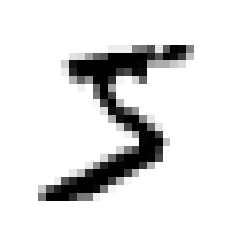

In [5]:
# Print the shape of the training data and test labels
print(train_X_ann.shape, test_y_d.shape, '\n')

# Print the range of pixel values
print(train_X_ann.min(), train_X_ann.max(), '\n')

# Print the number of data with each label in both the training and test sets
_, counts_tr = np.unique(train_y_a, return_counts=True)
_, counts_te = np.unique(test_y_d, return_counts=True)
for i in range(10):
    print(i, '|', counts_tr[i], '|', counts_te[i])
    
# Plot an example image
plt.imshow(train_X_ann[0], cmap='gray_r'), plt.axis('off');

### Data Processing

Let's process the data a bit for our purposes. We
- **Add a channel** axis to the data so that it will cooperate with Keras
- **Scale the pixel values** to be in the interval [0, 1], which also has the effect of converting them from integers to floats
- **Split the testing data** into testing and validation data

N.B. - our variable names can help us remember the shapes of our data.
 - train_X_ann1 => training data that is a tensor (X) of shape ann1, where a is 60,000 and n is 28
 - train_y_a => training labels in the form of a vector (y) of shape a
 - Likewise for testing/validation data

In [6]:
# Add color channel
train_X_ann1 = np.expand_dims(train_X_ann, axis=-1)
test_X_dnn1 = np.expand_dims(test_X_dnn, axis=-1)

# Scale pixel values
train_X_ann1 = train_X_ann1.astype('float32')/255.0
test_X_dnn1 = test_X_dnn1.astype('float32')/255.0

# Split testing data
valid_X_bnn1 = test_X_dnn1[:5000]
test_X_bnn1 = test_X_dnn1[5000:]

valid_y_b = test_y_d[:5000]
test_y_b = test_y_d[5000:]

# Building the Autoencoder

Now we can define our autoencoder. We will define the autoencoder as one model, and then **split it** into an encoder and a decoder model **after training**.

First, we import the `Sequential` model, the `layers` class, and the `Adam` optimizer from Keras.

We then define our autoencoder with a simple sequence of convolutional layers and maxpoolings (encoding), followed by convolutions and upscaling (decoding). We also save variables which correspond to both the encoder and decoder depths. These will be useful later when we split the autoencoder.

In [5]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

def autoencoder(in_shape=(28,28,1)):
    model = Sequential()
    # encoder
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=in_shape))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.encoder_depth = 6
    # decoder
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    model.decoder_depth = 7
    return model

auto = autoencoder()

auto.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='mse', metrics=['accuracy'])

## Training the Autoencoder

Next, we can begin training our network. Note that we are using the **same data for inputs and targets**. This is because we are trying to get our network to build reconstructions that *match* the input.

In [6]:
train_num = 60000  # max 60000
valid_num = 5000  # max 5000

auto.fit(train_X_ann1[:train_num], train_X_ann1[:train_num],
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(valid_X_bnn1[:valid_num], valid_X_bnn1[:valid_num]))

Train on 60000 samples, validate on 5000 samples
Epoch 1/50
60000/60000 [==============================] - 37s 625us/sample - loss: 0.0939 - accuracy: 0.7582 - val_loss: 0.0429 - val_accuracy: 0.8048
Epoch 2/50
60000/60000 [==============================] - 32s 527us/sample - loss: 0.0403 - accuracy: 0.7973 - val_loss: 0.0362 - val_accuracy: 0.8089
Epoch 3/50
60000/60000 [==============================] - 35s 578us/sample - loss: 0.0346 - accuracy: 0.8003 - val_loss: 0.0317 - val_accuracy: 0.8109
Epoch 4/50
60000/60000 [==============================] - 34s 560us/sample - loss: 0.0304 - accuracy: 0.8026 - val_loss: 0.0286 - val_accuracy: 0.8121
Epoch 5/50
60000/60000 [==============================] - 34s 559us/sample - loss: 0.0277 - accuracy: 0.8042 - val_loss: 0.0263 - val_accuracy: 0.8135
Epoch 6/50
60000/60000 [==============================] - 33s 553us/sample - loss: 0.0256 - accuracy: 0.8054 - val_loss: 0.0246 - val_accuracy: 0.8144
Epoch 7/50
60000/60000 [=====================

## Splitting the Autoencoder  / Saving the Models

Now that training is done, we can **split the autoencoder in half** to extract our encoder and decoder networks so that we can experiment with each of them individually.

In [7]:
def extract_coders(autoencoder_model):
    encd = autoencoder_model.encoder_depth
    decd = autoencoder_model.decoder_depth
    
    encoder = Sequential()
    for idx in range(0, encd):
        encoder.add(autoencoder_model.get_layer(index=idx))
        
    decoder = Sequential()
    for idx in range(encd, encd+decd):
        decoder.add(autoencoder_model.get_layer(index=idx))
        
    return encoder, decoder

encoder, decoder = extract_coders(auto)

We make a prediction using the decoder to intialize its input shape, and then save both the encoder and decoder models

In [8]:
decoder.predict(encoder.predict(test_X_bnn1[:1]))

encoder.save('encoder')
decoder.save('decoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: encoder\assets
INFO:tensorflow:Assets written to: decoder\assets


## First Look at Reconstruction Performance

Let's see how the autoencoder performs by comparing it to some of the original images. We use pyplot to display our images.

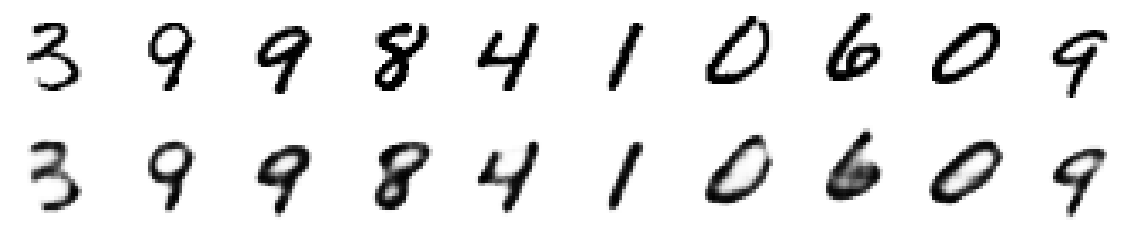

In [11]:
import matplotlib.pyplot as plt

# Number to encode/decode
number = 20
decoded = auto.predict(test_X_bnn1[:number])

n = 10
f, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(0, n):
    # Display original
    ax[0, i].imshow(test_X_bnn1[i].reshape(28, 28), cmap='gray_r')
    ax[0, i].axis('off')

    # Display reconstruction
    ax[1, i].imshow(decoded[i].reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[1, i].axis('off')
plt.show()

# Experimenting with the Decoder

Now we can start experimenting with our encoder/deocder networks to understand their behavior. Let's start off by exploring the behavior of the decoder. 

## Decoding the Origin

First, we can decode the latent-space origin to see what we get:

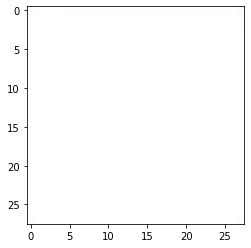

In [12]:
plt.imshow(decoder.predict(np.zeros((1,4,4,8))).reshape(28, 28), cmap='gray_r', clim=(0,1))

We see that the decoder maps the origin to **nothing** in particular, which is sensible. The origin (i.e. zero vector in this space) should be *impartial towards all feature encodings* - the basis centered on the origin defines directions that represent encodings of particular features.

If we set the colormap to be between the min/max values in the prediction, we see edge effects that are artifacts of convolution. Besides this, we observe that all of the pixels have essentially the same value - a truly agnostic latent space point.

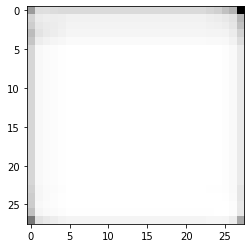

In [13]:
plt.imshow(decoder.predict(np.zeros((1,4,4,8))).reshape(28, 28), cmap='gray_r')

### Scaling along an axis

To further characterize the latent space, we can **scale along a line in the latent space to see how the decodings change**.

We take an example "3" from the dataset. First, we observe the original datum and our reconstruction of it for reference, where we have set the colormap range to \[0,1\] to yield a fair comparison.

(<matplotlib.image.AxesImage at 0x17b97d19988>, (-0.5, 27.5, 27.5, -0.5))

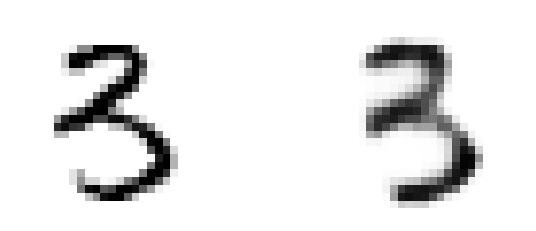

In [11]:
encoded_image = encoder.predict(test_X_bnn1[:1])

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(test_X_bnn1[:1].reshape(28, 28), cmap='gray_r', clim=(0,1)), ax[0].axis('off')
ax[1].imshow(decoder.predict(encoded_image).reshape(28, 28), cmap='gray_r', clim=(0,1)), ax[1].axis('off')

We now take the point in the encoding space that corresponds to this reconstruction and **scale it by powers of two**, sampling points on a line between the original datum encoding and the origin in the latent space. We can then take these points and decode them to observe the behavior, as below:

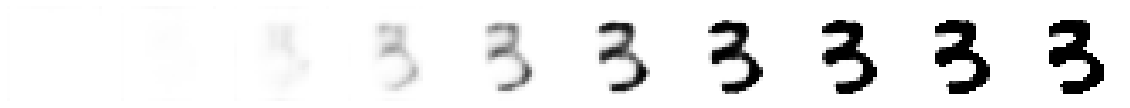

In [16]:
encoded_image = encoder.predict(test_X_bnn1[:1])

n = 10
f, ax = plt.subplots(1, 10, figsize=(20, 4))
for i in range(0, n):
    # Scale the encoding by powers of two
    ax[i].imshow(decoder.predict(encoded_image*2**(-5+i)).reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[i].axis('off')
plt.show()

We see that, as we travel along this line away from the origin, the decodings become more severe. In effect, we are traveling further and further **away from uncertainty/ambiguity**, and more **towards a notion of what it means to "be" 3**. 

## Adding noise

Instead of traveling directly away from the origin, we can think about taking a small stroll away from our latent-space point in a random direction and decoding points along the way. We expect our encoding space to be *well behaved on local patches* - that is, we should see no abrupt changes in the form of the decoded images if we sample locally.

We add noise sampled from a Gaussian with mean 0 and standard deviation of 0.1 to our point of interest, scaling it's amplitude from left to right in the images below. This has the effect of taking **larger and larger steps away from our point of interest in our randomly-selected direction**.

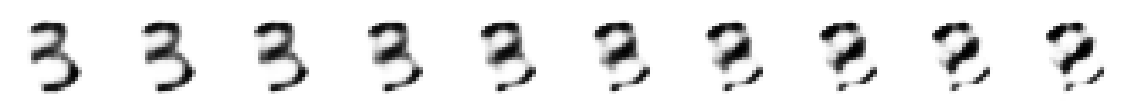

In [17]:
n = 10
noise = np.random.normal(0, .16, 4*4*8).reshape(1, 4, 4, 8)

f, ax = plt.subplots(1, 10, figsize=(2*n, 2))
for i in range(0, n):
    ax[i].imshow(decoder.predict(encoded_image+i*noise).reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[i].axis('off')
plt.show()

We see a smooth transition from our original decoding to another shape that looks vaguely like an 8

## Increasing the standard deviation of the noise

We can also observe the effect of increasing the standard deviation of the noise. It is important to note here that unlike in the last section in which we were using the same noise and simply _amplifying_ it, we are now sampling from a new distribution in each image with greater and greater standard deviations. 

This is to illustrate the fact that as we take bigger steps away from our point we are becoming less "like" our 3, but in **many different ways corresponding to many different directions**, despite the fact that they **all converge locally to the same 3**.

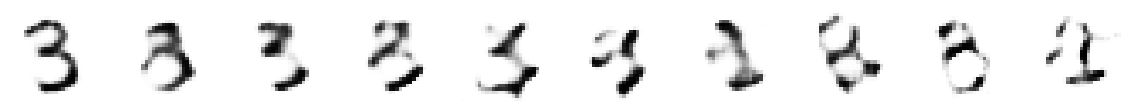

In [18]:
n = 10
f, ax = plt.subplots(1, 10, figsize=(20, 4))
for i in range(0, n):
    noise = np.random.normal(0, 1.1**(-5+i), 4*4*8)
    noise = noise.reshape(1, 4, 4, 8)
    ax[i].imshow(decoder.predict(encoded_image+noise).reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[i].axis('off')
plt.show()

## Walking in several directions

We can succinctly combine the two above sections as below. Here, each **row** corresponds to a **randomly selected direction** to walk in the encoded space, and the **columns** correspond to the **decoded representations as we travel further in that direction** away from our original point

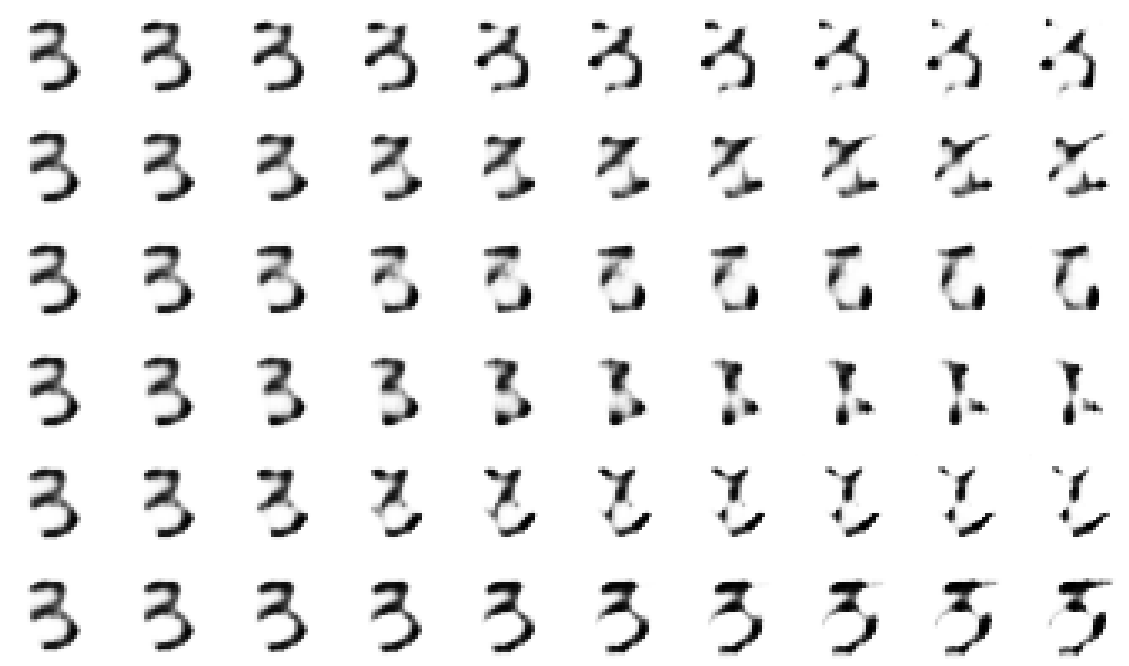

In [19]:
n = 10
num_dir = 6

f, ax = plt.subplots(num_dir, 10, figsize=(2*n, 2*num_dir))
for dir in range(0, num_dir):
    # Generate new noise for each different direction
    noise = np.random.normal(0, .16, 4*4*8).reshape(1, 4, 4, 8)
    for i in range(0, n):
        if num_dir == 1:
            ax[i].imshow(decoder.predict(encoded_image+i*noise).reshape(28, 28), cmap='gray_r', clim=(0,1))
            ax[i].axis('off')
        else:    
            ax[dir, i].imshow(decoder.predict(encoded_image+i*noise).reshape(28, 28), cmap='gray_r', clim=(0,1))
            ax[dir, i].axis('off')
plt.show()

# Exploring the encoded space

Now that we have characterized the behavior of our decoder a bit and used it to understand the nature of our latent space, let's see if we can extract any useful information **directly from the latent space itself**.

First, we isolate 5 instances of each digit into a variable called `digits`, where the index corresponds to the array containing the images (i.e. a list of ten 5x28x28x1 arrays)

In [20]:
filters = []
for i in range(10):
    filters.append(np.where(test_y_b[:150] == i))
    
digits = []
for i in range(10):
    digits.append(test_X_bnn1[filters[i]][:5])

We plot the instances below:

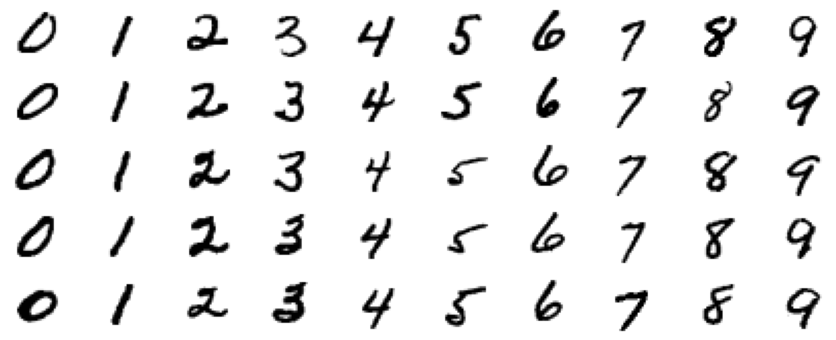

In [21]:
f, ax = plt.subplots(5, 10, figsize=(15, 6))
for d_idx, digit in enumerate(digits):
    for i in range(5):
        ax[i, d_idx].imshow(digit[i,:,:,0], cmap='gray_r', clim=(0,1)), ax[i, d_idx].axis('off')
plt.show()

We can now encode all of this data to yield the variable `encoded_digits`, a list of ten 5x4x4x8 arrays

In [22]:
encoded_digits = []
for i in range(10):
    encoded_digits.append(encoder.predict(digits[i]))

## Comparing Encodings of the Same Digit

We can try to observe patterns in the *encoded representations of the same digit*. To do this, we **plot slices of the encoded representations** of the same digit. Recall that the shape of an individual encoding is 4x4x8, so we plot eight 4x4 images for one encoding. Below we do this with the number 0, where the rows correspond to our 5 instances and the columns correspond to our 8 slices.

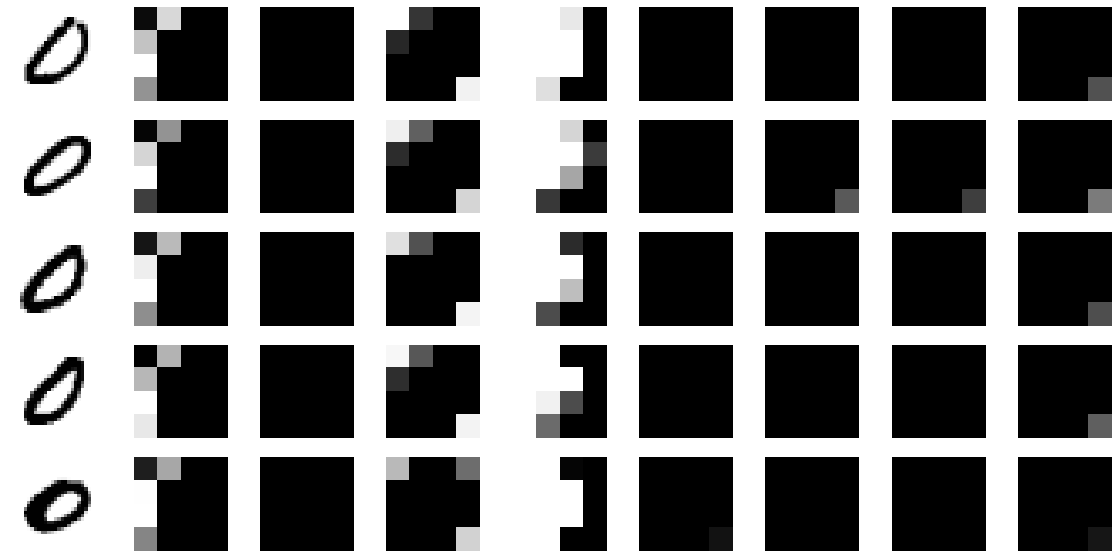

In [23]:
number = 0
num_inst = 5
num_slice = 8

f, ax = plt.subplots(num_inst, num_slice+1, figsize=(20, 10))
for j in range(num_inst):
    ax[j, 0].imshow(digits[number][j,:,:,0], cmap='gray_r', clim=(0,1)), ax[j, 0].axis('off')
    for i in range(num_slice):
        ax[j, i+1].imshow(encoded_digits[number][j,:,:,i], cmap='gray_r', clim=(0,1))
        ax[j, i+1].axis('off')
plt.show()

The encodings are remarkably similar for each digit. The slices are nearly identical in each case, so it is difficult to map any observable features in the digits to encoded features in the latent space. The digits in this case are all very similar, so perhaps this is to be expected. They are all slanting to the right and none have overhangs or breaks, and most even have similar linewidths.

## Comparing Encodings of Different Digits

We can also compare one sliced encoding for *each digit*, where each row corresponds to the digit of its index and each column again represents a slice of the encoding.

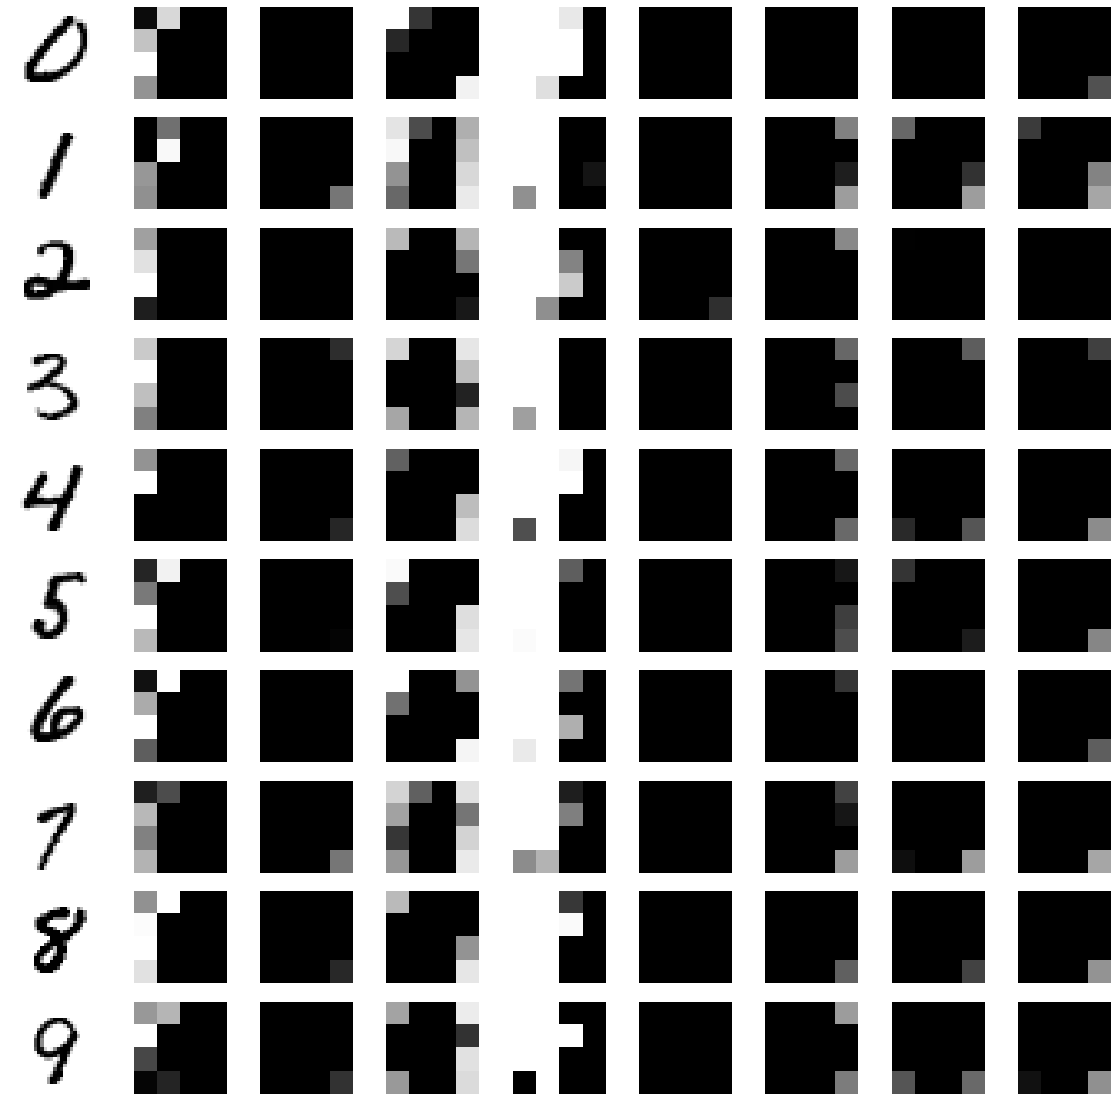

In [24]:
instance_index = 0
num_digits = 10
num_slice = 8

f, ax = plt.subplots(num_digits, num_slice+1, figsize=(20, 20))
for j in range(num_digits):
    ax[j, 0].imshow(digits[j][instance_index,:,:,0], cmap='gray_r', clim=(0,1)), ax[j, 0].axis('off')
    for i in range(num_slice):
        ax[j, i+1].imshow(encoded_digits[j][instance_index,:,:,i], cmap='gray_r', clim=(0,1))
        ax[j, i+1].axis('off')
plt.show()

Interestingly, there is a great amount of overlap in the encodings of each instance. In particular, the 5th slice is almost identical in each case. This implies that our latent space dimension could likely be reduced even further, potentially drastically, without a great detriment to performance.

# Noise Reduction

Now that we have begun to understand the behavior of our autoencoder, let's try training an autoencoder for noise reduction. First, we add some noise to our training data

In [25]:
noisy_train = train_X_ann1 + np.random.normal(0, 0.1, train_X_ann1.shape)
noisy_test = test_X_bnn1 + np.random.normal(0, 0.1, test_X_bnn1.shape)

Now we can train our autoencoder. Note that unlike our previous training, the **inputs and targets are no longer identical**. Since we want to learn to denoise, the input images are the **noisy** images, while the target images are the **original** images.

In [26]:
train_num = 60000  # max 60000
valid_num = 5000  # max 5000

auto_noisy = autoencoder()

auto_noisy.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='mse', metrics=['accuracy'])

auto_noisy.fit(noisy_train[:train_num], train_X_ann1[:train_num],
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(noisy_test[:valid_num], valid_X_bnn1[:valid_num]))

Train on 60000 samples, validate on 5000 samples
Epoch 1/50
60000/60000 [==============================] - 35s 584us/sample - loss: 0.0806 - accuracy: 0.7911 - val_loss: 0.0867 - val_accuracy: 0.7525
Epoch 2/50
60000/60000 [==============================] - 32s 528us/sample - loss: 0.0401 - accuracy: 0.7960 - val_loss: 0.0987 - val_accuracy: 0.7435
Epoch 3/50
60000/60000 [==============================] - 34s 559us/sample - loss: 0.0335 - accuracy: 0.8006 - val_loss: 0.1002 - val_accuracy: 0.7510
Epoch 4/50
60000/60000 [==============================] - 34s 567us/sample - loss: 0.0297 - accuracy: 0.8031 - val_loss: 0.1065 - val_accuracy: 0.7447
Epoch 5/50
60000/60000 [==============================] - 34s 561us/sample - loss: 0.0271 - accuracy: 0.8047 - val_loss: 0.1080 - val_accuracy: 0.7458
Epoch 6/50
60000/60000 [==============================] - 34s 564us/sample - loss: 0.0253 - accuracy: 0.8058 - val_loss: 0.1113 - val_accuracy: 0.7427
Epoch 7/50
60000/60000 [=====================

As above, we save our models

In [27]:
encoder_noisy, decoder_noisy = extract_coders(auto_noisy)

decoder_noisy.predict(encoder_noisy.predict(test_X_bnn1[:1]))

encoder_noisy.save('encoder_noisy')
decoder_noisy.save('decoder_noisy')

INFO:tensorflow:Assets written to: encoder_noisy\assets
INFO:tensorflow:Assets written to: decoder_noisy\assets


Let's take a look at how our model performs. We'll select 10 images from the testing set and display the **original images**, the images **after noise was added**, and the images **after being denoised** using our autoencoder.

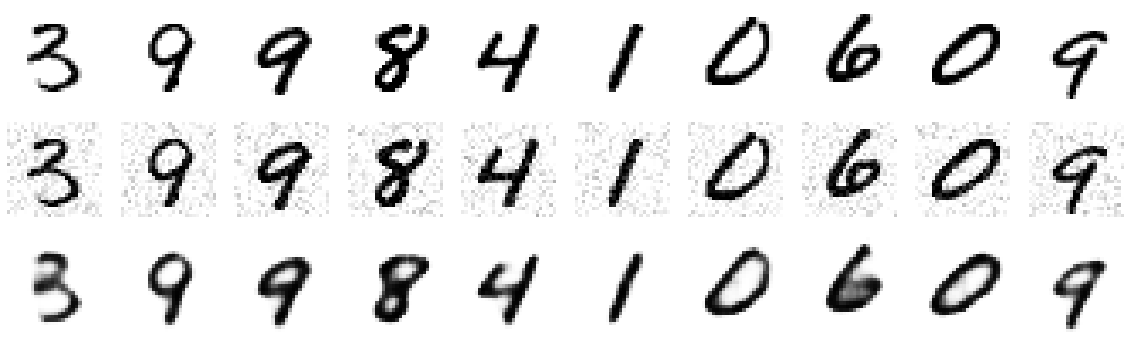

In [28]:
import matplotlib.pyplot as plt

n = 10
f, ax = plt.subplots(3, 10, figsize=(20, 6))
for i in range(0, n):
    # Original
    ax[0, i].imshow(test_X_bnn1[i].reshape(28, 28), cmap='gray_r'), ax[0, i].axis('off')

    # Noise added
    ax[1, i].imshow(noisy_test[i].reshape(28, 28), cmap='gray_r', clim=(0,1)), ax[1, i].axis('off')
    
    # Noise removed
    enc = encoder_noisy.predict(test_X_bnn1[i].reshape(1,28,28,1))
    ax[2, i].imshow(decoder_noisy.predict(enc).reshape(28,28), cmap='gray_r', clim=(0,1)), ax[2, i].axis('off')
plt.show()

We see good performance! Now, let's start experimenting with the model

## How does the autoencoder behave as noise is increased?

First, we can try to get a sense of how well our autoencoder performs as the magnitude of our noise increases. Below we plot the same image with **increasing noise** added, as well as our autoencoder's **reconstruction** of these images. 

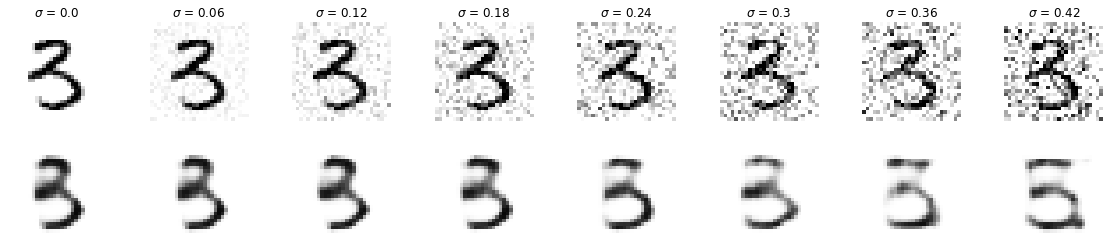

In [29]:
# Number of noise steps
number = 8

f, ax = plt.subplots(2, number, figsize=(2*n, 4))
for i in range(0, number):
    # Noise added
    noisy = test_X_bnn1[:1] + np.random.normal(0, 0.06*i, test_X_bnn1[:1].shape)
    ax[0, i].imshow(noisy.reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[0, i].axis('off')
    ax[0, i].set_title('$\sigma$ = '+str(0.06*i))
    
    # Noise removed
    enc = encoder_noisy.predict(noisy.reshape(1,28,28,1))
    ax[1, i].imshow(decoder_noisy.predict(enc).reshape(28,28), cmap='gray_r', clim=(0,1)), ax[1, i].axis('off')
plt.show()

Our autoencoder performs reasonably well, but perhaps not as well as a human would at high noise levels. Specifically, the denoised image for the noisiest input looks more like a 5, but a human would likely be able to tell that the noisy image in fact represents a 3.

# Noisy vs. Denoised Classification Accuracy

Let's train a classifier to see **whether or not it is worth it to denoise images with our autoencoder before classification**. We follow a standard CNN architecture. Note the loss function is now categorical crossentropy as we have changed from the task of reconstruction to the task of classification.

In [30]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

def classifier_model():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(10, activation='softmax'))
    return classifier

classifier = classifier_model()

# compile model
classifier.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

We train as before, except this time our **targets are the labels** of the inputs (i.e. which digit the image represents). Note that we have also converted the labels from *ordinally-encoded* to *one-hot-encoded* using keras' `to_categorical()` function.

In [31]:
from tensorflow.keras.utils import to_categorical

train_num = 60000  # max 60000
valid_num = 5000  # max 5000

history = classifier.fit(train_X_ann1[:train_num], to_categorical(train_y_a[:train_num], num_classes=10),
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(valid_X_bnn1[:valid_num], to_categorical(valid_y_b[:valid_num], num_classes=10)))

Train on 60000 samples, validate on 5000 samples
Epoch 1/50
60000/60000 [==============================] - 26s 428us/sample - loss: 0.2869 - accuracy: 0.9201 - val_loss: 0.1093 - val_accuracy: 0.9674
Epoch 2/50
60000/60000 [==============================] - 26s 436us/sample - loss: 0.0753 - accuracy: 0.9777 - val_loss: 0.0841 - val_accuracy: 0.9736
Epoch 3/50
60000/60000 [==============================] - 26s 433us/sample - loss: 0.0528 - accuracy: 0.9847 - val_loss: 0.0707 - val_accuracy: 0.9764
Epoch 4/50
60000/60000 [==============================] - 26s 437us/sample - loss: 0.0418 - accuracy: 0.9874 - val_loss: 0.0546 - val_accuracy: 0.9818
Epoch 5/50
60000/60000 [==============================] - 26s 439us/sample - loss: 0.0341 - accuracy: 0.9897 - val_loss: 0.0573 - val_accuracy: 0.9818
Epoch 6/50
60000/60000 [==============================] - 26s 438us/sample - loss: 0.0286 - accuracy: 0.9916 - val_loss: 0.0590 - val_accuracy: 0.9804
Epoch 7/50
60000/60000 [=====================

We save the classifier and test our accuracy on the original dataset, the noisy dataset (Gaussian mean=0, SD=0.1), and the denoised images.

In [33]:
classifier.save('mnist_classifier_autoencoders')

INFO:tensorflow:Assets written to: mnist_classifier_autoencoders\assets


In [34]:
accs = {}
accs['original_acc'] = classifier.evaluate(test_X_bnn1, to_categorical(test_y_b))[1];
accs['noisy_acc'] = classifier.evaluate(noisy_test, to_categorical(test_y_b))[1];
enc = encoder_noisy.predict(noisy_test)
accs['decoded_acc'] = classifier.evaluate(decoder_noisy.predict(enc), to_categorical(test_y_b))[1];
for a in accs:
    print(a, ' : ', accs[a])

5000/5000 [==============================] - 1s 272us/sample - loss: 0.2414 - accuracy: 0.9544
original_acc  :  0.997
noisy_acc  :  0.9956
decoded_acc  :  0.9544


As we can see, for low-noise images it is more accurate to **directly classify on the noisy images** rather than **classify on denosied images**. This has the added benefit of being less computationally expensive.

## Does this change as noise grows?

Let's examine if this observation changes as the images get noisier. We'll repeatedly increase the standard deviation of the noise on our testing data and then see if the classifier works better on the noisy or denosied data.

Below we plot the an example of the noisy and denoised images that were input into the classifier for each noise level, along with the accuracy of the classifier for each type at that noise level. 

5000/5000 [==============================] - 1s 272us/sample - loss: 1.4927 - accuracy: 0.7850


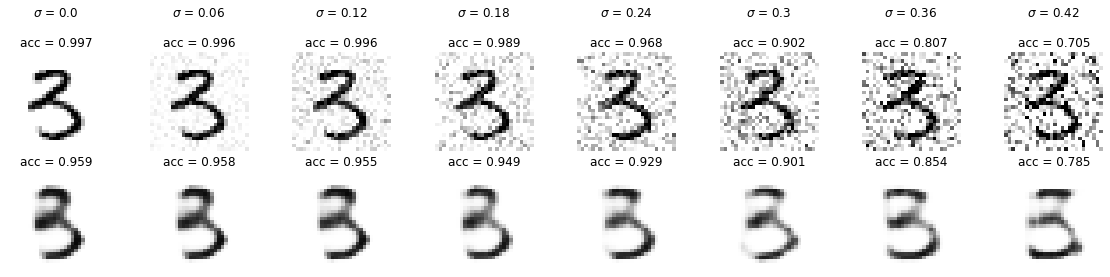

In [35]:
number = 8

f, ax = plt.subplots(2, number, figsize=(2*n, 4))
for i in range(0, number):
    # Plot noisy with accuracy
    noisy = test_X_bnn1 + np.random.normal(0, .06*i, test_X_bnn1.shape)
    acc = classifier.evaluate(noisy, to_categorical(test_y_b))[1]
    
    ax[0, i].imshow(noisy[:1].reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[0, i].axis('off')
    ax[0, i].set_title('$\sigma$ = '+str(0.06*i)+' \n\nacc = '+str(acc)[:5])
    
    # Plot decoded with accuracy
    enc = encoder_noisy.predict(noisy)
    decoded = decoder_noisy.predict(enc)
    acc = classifier.evaluate(decoded, to_categorical(test_y_b))[1]
    
    ax[1, i].imshow(decoded[:1].reshape(28,28), cmap='gray_r', clim=(0,1))
    ax[1, i].axis('off')
    ax[1, i].set_title('acc = '+str(acc)[:5])

plt.show()

As we can see, although classifying on the denoised images is **less accurate** initially, its rate of degredation as noise is increased is **less severe**, ultimately being *more* accurate for very noisy images. While the accuracy on classifying the noisy images **dropped 29%** as the standard deviation of the noise increased from 0 to 0.42, the accuracy on classifying the denoised images **drops only 18%**

# Training Separate Models for Noisy and Denoised Classification

We recall that the classifier that is being used above was trained on the original data. Lets try training separate classifiers for noisy and denoised data to see how our previous results change. We fix the noise standard deviation at 0.24, although we could set it to be within a range during training to produce a more sophisticated model, but leaving it fixed will suffice for our purposes.

In [36]:
# Create noisy sets
noisy_train = train_X_ann1 + np.random.normal(0, 0.24, train_X_ann1.shape)
noisy_valid = valid_X_bnn1 + np.random.normal(0, 0.24, valid_X_bnn1.shape)
noisy_test = test_X_bnn1 + np.random.normal(0, 0.24, test_X_bnn1.shape)

# Create denoised sets
denoise_train = decoder_noisy.predict(encoder_noisy.predict(noisy_train))
denoise_valid = decoder_noisy.predict(encoder_noisy.predict(noisy_valid))
denoise_test = decoder_noisy.predict(encoder_noisy.predict(noisy_test))

We train on the noisy/denoised data respectively, using our original labels.

In [37]:
train_num = 60000  # max 60000
valid_num = 5000  # max 5000

classifier_noise = classifier_model()
classifier_denoise = classifier_model()

classifier_noise.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
classifier_denoise.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

history_class_noise = classifier_noise.fit(noisy_train[:train_num], to_categorical(train_y_a[:train_num], num_classes=10),
                        epochs=50,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(noisy_valid[:valid_num], to_categorical(valid_y_b[:valid_num], num_classes=10)))

classifier.save('minst_classifier_autoencoders_noisy')

history_class_denoise = classifier_denoise.fit(denoise_train[:train_num], to_categorical(train_y_a[:train_num], num_classes=10),
                        epochs=50,
                        batch_size=128,
                        shuffle=True,
                        validation_data=(denoise_valid[:valid_num], to_categorical(valid_y_b[:valid_num], num_classes=10)))

classifier.save('minst_classifier_autoencoders_denoised')

Train on 60000 samples, validate on 5000 samples
Epoch 1/50
60000/60000 [==============================] - 42s 697us/sample - loss: 0.3809 - accuracy: 0.8858 - val_loss: 0.2094 - val_accuracy: 0.9348
Epoch 2/50
60000/60000 [==============================] - 41s 688us/sample - loss: 0.1255 - accuracy: 0.9621 - val_loss: 0.1301 - val_accuracy: 0.9588
Epoch 3/50
60000/60000 [==============================] - 41s 681us/sample - loss: 0.0901 - accuracy: 0.9724 - val_loss: 0.1231 - val_accuracy: 0.9586
Epoch 4/50
60000/60000 [==============================] - 41s 680us/sample - loss: 0.0710 - accuracy: 0.9781 - val_loss: 0.0900 - val_accuracy: 0.9710
Epoch 5/50
60000/60000 [==============================] - 41s 689us/sample - loss: 0.0577 - accuracy: 0.9825 - val_loss: 0.0807 - val_accuracy: 0.9700
Epoch 6/50
60000/60000 [==============================] - 41s 681us/sample - loss: 0.0487 - accuracy: 0.9858 - val_loss: 0.0809 - val_accuracy: 0.9706
Epoch 7/50
60000/60000 [=====================

We again compare accuracies

5000/5000 [==============================] - 1s 284us/sample - loss: 0.6812 - accuracy: 0.8852


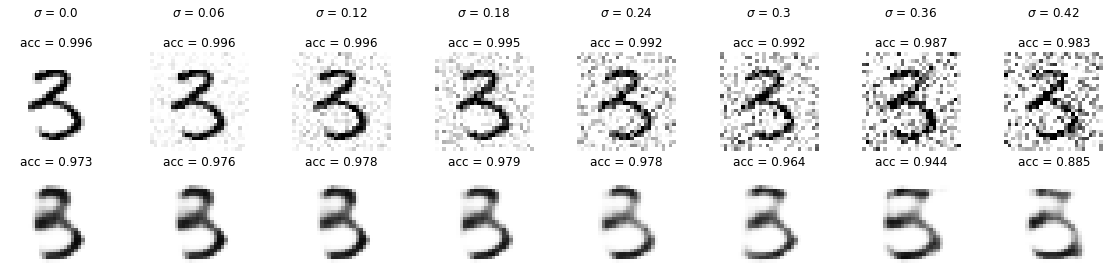

In [38]:
number = 8

f, ax = plt.subplots(2, number, figsize=(2*n, 4))
for i in range(0, number):
    # Plot noisy with accuracy
    noisy = test_X_bnn1 + np.random.normal(0, .06*i, test_X_bnn1.shape)
    acc = classifier_noise.evaluate(noisy, to_categorical(test_y_b))[1]
    
    ax[0, i].imshow(noisy[:1].reshape(28, 28), cmap='gray_r', clim=(0,1))
    ax[0, i].axis('off')
    ax[0, i].set_title('$\sigma$ = '+str(0.06*i)+' \n\nacc = '+str(acc)[:5])
    
    # Plot decoded with accuracy
    enc = encoder_noisy.predict(noisy)
    decoded = decoder_noisy.predict(enc)
    acc = classifier_denoise.evaluate(decoded, to_categorical(test_y_b))[1]
    
    ax[1, i].imshow(decoded[:1].reshape(28,28), cmap='gray_r', clim=(0,1))
    ax[1, i].axis('off')
    ax[1, i].set_title('acc = '+str(acc)[:5])

plt.show()

We can see that **both classifiers unsurprisingly outperform the original classifier** on their respective data classes. The noisy classifier outperforms the denoised classifier significantly, and performs well across noise thresholds despite our observation above that we used a fixed standard deviation on the noise when training the model.

Lastly, we note that overtraining occurred for both of the above models but more significantly for the denoised classifier. How much of the lower relative performance of this classifier compared to the noisy one is due to greater overtraining is hard to say, but should be pointed out. A more sophisticated training approach that saves the model between underfitting & overfitting would help, but is beyond the scope of this notebook.

# BONUS: How does accuracy drop on repeated encoding/decoding

We can repeatedly encode/decode the original data to see how much the classification performance degrades as the iteration number grows. Theoretically, a classification accuracy that does not degrade quickly with repeated encodings/decodings implies a robust autoencoder given that the amount of compounded error is low, which in turn implies close representational and reconstructional accuracy between the original data and its decodings.

1000/1000 [==============================] - 0s 278us/sample - loss: 3.6277 - accuracy: 0.6430


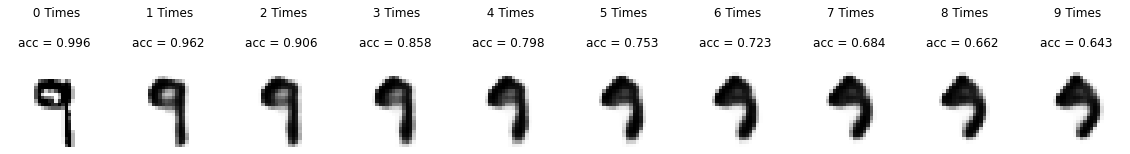

In [39]:
# Decoded data (just original data for first loop)
dec = test_X_bnn1

n = 10
f, ax = plt.subplots(1, n, figsize=(2*n, 6))
for i in range(0, n):
    # Calculate the accuracy of the classifier on this data
    acc = classifier.evaluate(dec, to_categorical(test_y_b))[1]
    
    # Plot the first example with the classifier accuracy across the whole dataset
    ax[i].imshow(dec[:1].reshape(28, 28), cmap='gray_r')
    ax[i].axis('off')
    ax[i].set_title(' '+str(i)+' Times\n\nacc = '+str(acc)[:5])

    # Encode/decode for the next loop
    dec = decoder_noisy.predict(encoder_noisy.predict(dec))

    

# Conclusions

In this notebook we:
- Looked at a recap of ordinary autoencoders
- Understood the structure of convolutional autoencoders (CAEs)
- Understood why CAEs are uniquely appropriate for dimensionality reduction in image/serial data
- Learned how to built/train a CAE, utilizing the MNIST dataset in the process
- Explored how our decoder behaves as we travel through the latent space
- Directly observed latent space encodings of similar and distinct digits
- Built a CAE for noise reduction
- Built a CNN for MNIST classification
- Explored whether or not using a CAE as a denoising preprocessing step for a classification CNN is worthwhile

**That's it for now! If you have any questions, comments, or concerns please feel free to send me a message using the contact form below.**

**If there's another topic you'd like me to cover, please send me a request through the contact form below!**